In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import flwr as fl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import logging
import multiprocessing
multiprocessing.set_start_method('spawn', force=True) # I don't know why but this makes CUDA run better for async systems (server client interactions)
from multiprocessing_helpers import (
    launch_client,
    # launch_server
    )


import time

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve
    )

# my py files
from device import move_to_device, get_device
from data import load_data
from lora import create_lora_model
from clients import FlowerClient
from differential_privacy import differential_privacy
from server import start_fl_server




logging.basicConfig(level=logging.INFO)


# list of  different experimental setup options:

scenarios = [
    {"name": "LoRA Only", "federated": False, "differential_privacy": False},
    {"name": "LoRA + Federated", "federated": True, "differential_privacy": False},
    {"name": "LoRA + Federated + DP", "federated": True, "differential_privacy": True},
]

# # Experiment Scenarios
# scenarios = [
#     {"name": "LoRA Only", "federated": False, "dp_mode": "none", "adaptive": False},
#     {"name": "LoRA + Federated (No DP)", "federated": True, "dp_mode": "none", "adaptive": False},
#     {"name": "Server-Side DP (Fixed)", "federated": True, "dp_mode": "server", "adaptive": False},
#     {"name": "Server-Side DP (Adaptive)", "federated": True, "dp_mode": "server", "adaptive": True},
#     # {"name": "Client-Side DP", "federated": True, "dp_mode": "client", "adaptive": False},
# ]



# List of transformers to test

models_to_test = [
    {"name": "prajjwal1/bert-tiny", "target_modules": ["query", "key", "value"]},
    {"name": "google/mobilebert-uncased", "target_modules": ["query", "key", "value"]},
    {"name": "distilbert-base-uncased", "target_modules": ["q_lin", "v_lin"]},
    {"name": "roberta-base", "target_modules": ["query", "key", "value"]},
    {"name": "microsoft/deberta-v3-base", "target_modules": ["query_proj", "key_proj", "value_proj"]},
    {"name": "gpt2", "target_modules": ["c_attn"]}
]

# Differential Privacy parameters
dp_params = {
    "noise_multiplier": 1.0,
    "max_grad_norm": 1.0,
}
# # Define different DP parameters to test
# noise_multipliers = [0.5, 1.0, 1.5]
# max_grad_norms = [0.5, 1.0, 1.5]
# Hyperparameters
epochs = 5

# # Additional variables to track metrics
# convergence_rounds = None
# loss_history = []  # Track loss over epochs
# client_accuracies = []  # Track accuracies for federated clients
# dropped_clients = 0  # Track dropped clients
# gradient_clipping_ratios = []  # Track gradient clipping ratios for differential privacy


results = pd.DataFrame(columns=["Model", "Scenario", "Accuracy", "Loss", "Precision", "Recall", "F1 Score", "ROC-AUC", "Training Time (s)", "Privacy Budget (ε)", "Convergence Rounds", "Convergence Stability"])




# def launch_server():
#     start_fl_server()



# def launch_client(model, trainloader, testloader, dp_enabled, dp_params):
#     # Create Flower client
#     client = FlowerClient(
#         model=model,
#         trainloader=trainloader,
#         testloader=testloader,
#         device=get_device(),
#         dp_enabled=dp_enabled,
#         dp_params=dp_params
#     )

#     # Start Flower client
#     fl.client.start_numpy_client(server_address="localhost:8080", client=client)


## Launch server process
# server_process = multiprocessing.Process(target=launch_server)
# logging.info("Starting FL server...")
# server_process.start()

# # Allow server to initialize
# time.sleep(5)

Prepare a DataFrame to store the results of each experiment:

In [2]:
# Dictionary to store evaluation data for all models and scenarios
evaluation_data = {}

for model_name in models_to_test:
    # Initialize tokenizer and data loaders
    tokenizer = AutoTokenizer.from_pretrained(model_name["name"])

    
    # trainloader = load_data(tokenizer, split="train[:10%]") # 10% for debugging 
    # testloader = load_data(tokenizer, split="test[:10%]")

    # Check if a padding token exists, and add one if not
    # Add a padding token only for GPT-2
     # Set a padding token if using GPT-2
    if model_name["name"] == "gpt2":
        tokenizer.pad_token = tokenizer.eos_token  # Use <eos> as <pad>
        logging.info("Added padding token for GPT-2")


    trainloader = load_data(tokenizer, split="train") # 100% for final run 
    testloader = load_data(tokenizer, split="test")
    for scenario in scenarios:
        logging.info(get_device())
        logging.info(f"Running experiment: {scenario['name']} with {model_name['name']}")
        # Initialize model
        model = create_lora_model(
            model_class=AutoModelForSequenceClassification,
            transformer_model=model_name["name"],
            rank=16,
            num_labels=2,
            target_modules=model_name["target_modules"],
            tokenizer=tokenizer
        )
        if model_name["name"] == "gpt2":
            model.config.pad_token_id = tokenizer.pad_token_id

        loss_history = []
        client_processes = []
        privacy_budget = None
         # Federated Learning Scenario
        if scenario["federated"]:
            for _ in range(10):  # Simulate 10 clients
                time.sleep(2)  # Delay to avoid simultaneous GPU initialization
                
                if scenario["differential_privacy"]:
                    # Efficiency Metrics
                    start_time = time.time()
                    # Start FL server
                    p = multiprocessing.Process(
                        target=launch_client,
                        args=(model,trainloader, testloader,scenario["differential_privacy"], dp_params)
                    )
                    p.start()
                    p.join()  # Wait for the client process to finish
                    # client_processes.append(p)
                    # time.sleep(2)  # Delay between client starts
                    # Calculate Training Time
                    training_time = time.time() - start_time
                    # Calculate ε based on noise multiplier and dataset properties (example approximation)
                    privacy_budget = 1 / dp_params["noise_multiplier"]
            

                else:
                    start_time = time.time()
                    p = multiprocessing.Process(
                        target=launch_client,
                        args=(model, trainloader, testloader,scenario["differential_privacy"], dp_params)
                    )
                    p.start()
                    p.join()  # Wait for the client process to finish
                    # client_processes.append(p)
                    # time.sleep(2)  # Delay between client starts
                    training_time = time.time() - start_time
            # Wait for all clients to finish before proceeding
            # logging.info(f"Waiting for all clients to complete scenario: {scenario['name']}")
            # wait_for_clients(client_processes)
            # logging.info(f"All clients completed scenario: {scenario['name']}")
                

        else:
            start_time = time.time()
            # Local training
            optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

            if scenario["differential_privacy"]:
                model, optimizer, trainloader = differential_privacy(model, optimizer, trainloader, **dp_params)
            criterion = torch.nn.CrossEntropyLoss()
            model.train()
            for epoch in range(epochs):  # Adjust epochs as needed
                logging.info(f"Epoch {epoch + 1}/{epochs}")
                epoch_loss = 0.0
                for batch in trainloader:
                    optimizer.zero_grad()

                    # GPU acceleration 
                    input_ids = move_to_device(batch["input_ids"])
                    attention_mask = move_to_device(batch["attention_mask"])
                    labels = move_to_device(batch["label"])

                    # The acual training
                    outputs = model(input_ids, attention_mask=attention_mask)
                    loss = criterion(outputs.logits, labels)
                    loss.backward()
                    optimizer.step()

                    epoch_loss += loss.item()

                loss_history.append(epoch_loss / len(trainloader))

            training_time = time.time() - start_time

        # Convergence Metrics
        convergence_stability = np.std(loss_history[-5:]) if len(loss_history) >= 5 else None

        # Evaluation
        criterion = torch.nn.CrossEntropyLoss()
        model.eval()
        total_loss, correct, total = 0.0, 0, 0
        all_preds, all_labels, all_probs = [], [], []  # Store predictions and true labels for additional metrics

        with torch.no_grad():
            for batch in testloader:
                # print(f"Processing batch of size: {len(batch['input_ids'])}")
                # print(batch["input_ids"].shape)
                if len(batch["input_ids"]) == 0:
                    logging.warning("Empty batch detected during evaluation.")
                    continue
                        
                # GPU acceleration 
                input_ids = move_to_device(batch["input_ids"])
                attention_mask = move_to_device(batch["attention_mask"])
                labels = move_to_device(batch["label"])

                # The actual testing/evaluation
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                preds = logits.argmax(dim=1)
                probs = torch.softmax(logits, dim=1)

                total_loss += criterion(logits, labels).item()

                # Accuracy Computations
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                
                # Store predictions and true labels
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())


                
            
        # Handle zero division and calculate accuracy
        accuracy = correct / total if total > 0 else 0.0
        loss = total_loss / len(testloader) if len(testloader) > 0 else 0.0


        # Calculate, precision, recall, F1, RUC-AUC and confusion matrix
        precision = precision_score(all_labels, all_preds, average="weighted")
        recall = recall_score(all_labels, all_preds, average="weighted")
        f1 = f1_score(all_labels, all_preds, average="weighted")
        # roc_auc = roc_auc_score(all_labels, all_preds) if len(set(all_labels)) == 2 else None
        roc_auc = roc_auc_score(all_labels, [p[1] for p in all_probs]) if len(set(all_labels)) == 2 else None
        conf_matrix = confusion_matrix(all_labels, all_preds)



        # Add new rows with .loc
        results.loc[len(results)] = {
            "Model": model_name["name"],
            "Scenario": scenario["name"],
            "Loss": total_loss / (len(testloader) if len(testloader) > 0 else 1),
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "ROC-AUC": roc_auc,
            "Training Time (s)": training_time,
            "Privacy Budget (ε)": privacy_budget,
            "Convergence Rounds": len(loss_history),
            "Convergence Stability": convergence_stability,
        }


        # Store data for visualization
        evaluation_data[(model_name["name"], scenario["name"])] = {
            "all_labels": all_labels,
            "all_probs": all_probs,
            "conf_matrix": conf_matrix,
            # "roc_auc": roc_auc,
        }



INFO:root:Batch input_ids shape: torch.Size([8, 512])
INFO:root:Batch labels shape: torch.Size([8])
INFO:root:Batch input_ids shape: torch.Size([8, 512])
INFO:root:Batch labels shape: torch.Size([8])
INFO:root:cuda:0
INFO:root:Running experiment: LoRA Only with prajjwal1/bert-tiny
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:root:Epoch 1/5
INFO:root:Epoch 2/5
INFO:root:Epoch 3/5
INFO:root:Epoch 4/5
INFO:root:Epoch 5/5
INFO:root:cuda:0
INFO:root:Running experiment: LoRA + Federated with prajjwal1/bert-tiny
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-str

In [3]:
# from transformers import AutoModel

# model = AutoModel.from_pretrained("microsoft/deberta-v3-base")
# print(model)

                        Model               Scenario  Accuracy          Loss  \
0         prajjwal1/bert-tiny              LoRA Only   0.77808  4.693270e-01   
1         prajjwal1/bert-tiny       LoRA + Federated   0.49988  7.065889e-01   
2         prajjwal1/bert-tiny  LoRA + Federated + DP   0.50052  7.024880e-01   
3   google/mobilebert-uncased              LoRA Only   0.49556  1.164812e+00   
4   google/mobilebert-uncased       LoRA + Federated   0.50000  4.472034e+06   
5   google/mobilebert-uncased  LoRA + Federated + DP   0.50000  2.437814e+06   
6     distilbert-base-uncased              LoRA Only   0.91404  2.120920e-01   
7     distilbert-base-uncased       LoRA + Federated   0.50000  6.984506e-01   
8     distilbert-base-uncased  LoRA + Federated + DP   0.49996  6.988984e-01   
9                roberta-base              LoRA Only   0.95084  1.338969e-01   
10               roberta-base       LoRA + Federated   0.50000  6.949708e-01   
11               roberta-base  LoRA + Fe

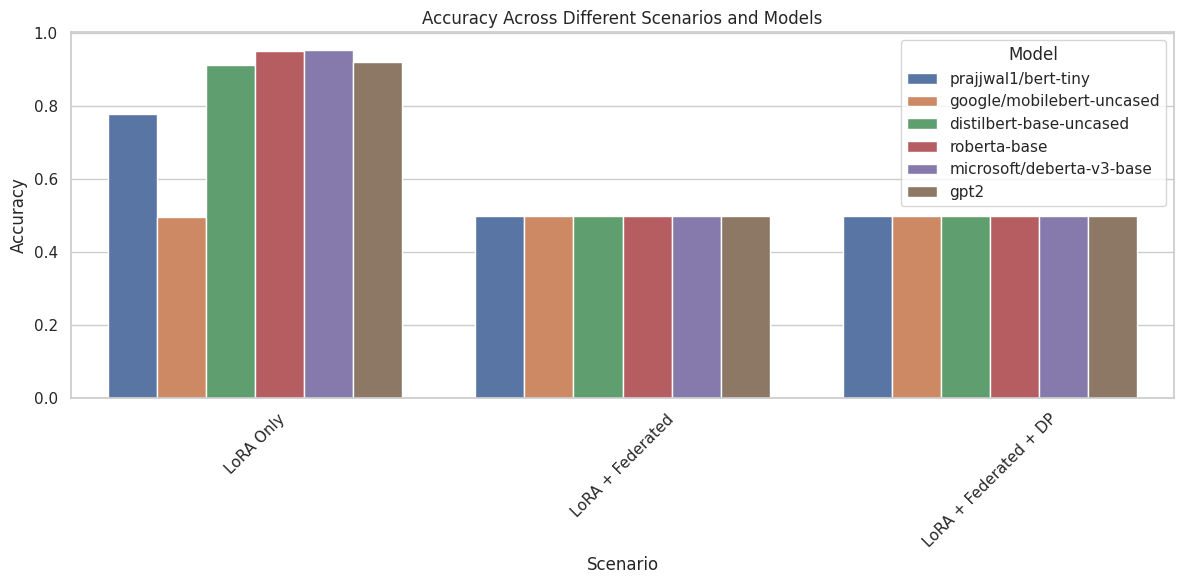

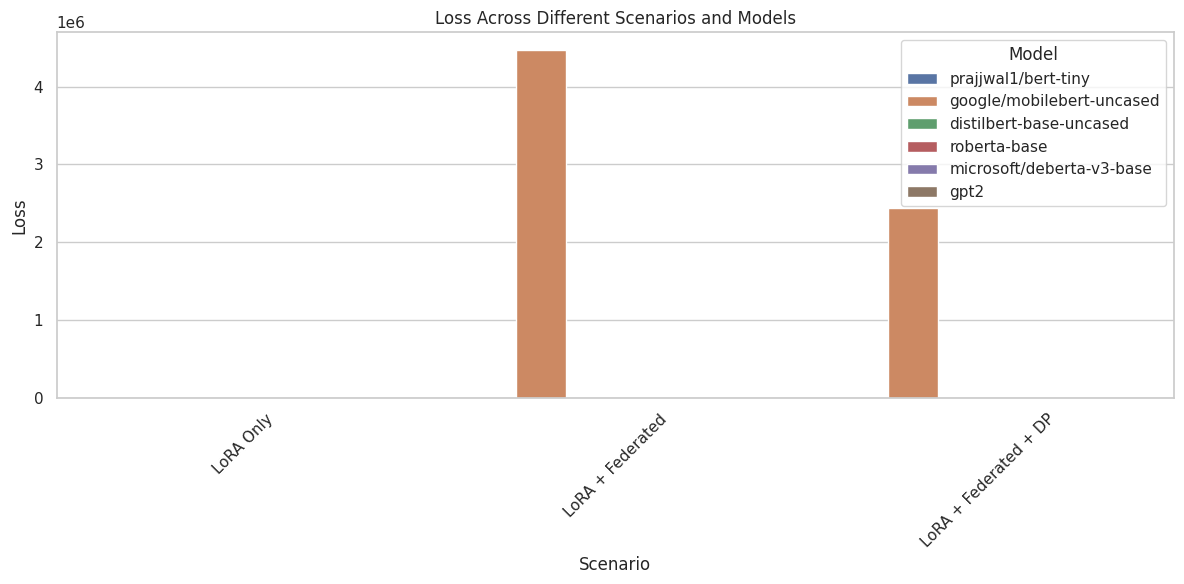

In [4]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv('results_2.csv', index=False)

# # Convert results to DataFrame
# results_df = pd.DataFrame(results)
# print(results_df)
# results_df.to_csv('results_2.csv', index=False)

# Accuracy visualization
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Scenario", y="Accuracy", hue="Model")
plt.title("Accuracy Across Different Scenarios and Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Loss visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Scenario", y="Loss", hue="Model")
plt.title("Loss Across Different Scenarios and Models")
plt.ylabel("Loss")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.show()
plt.close()

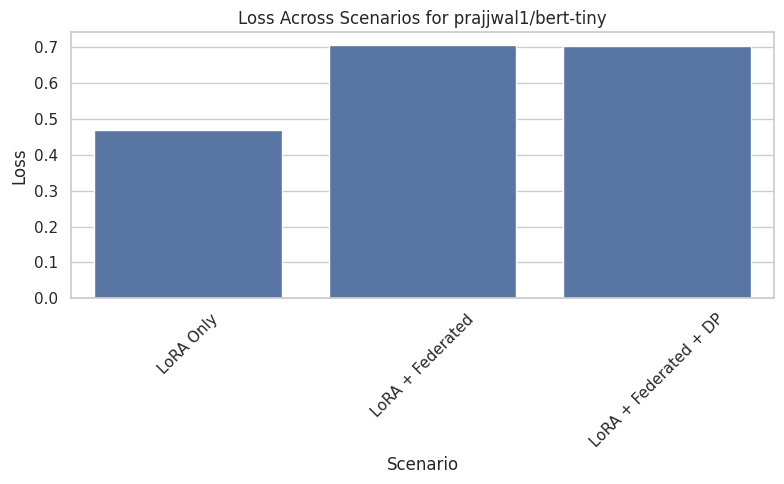

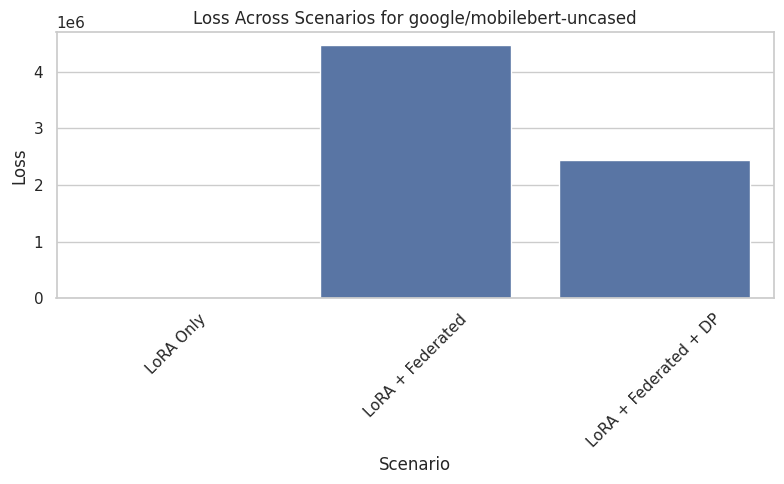

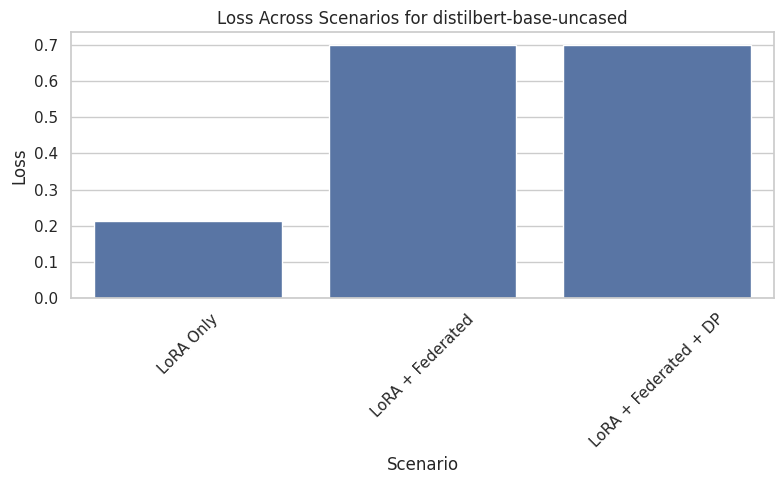

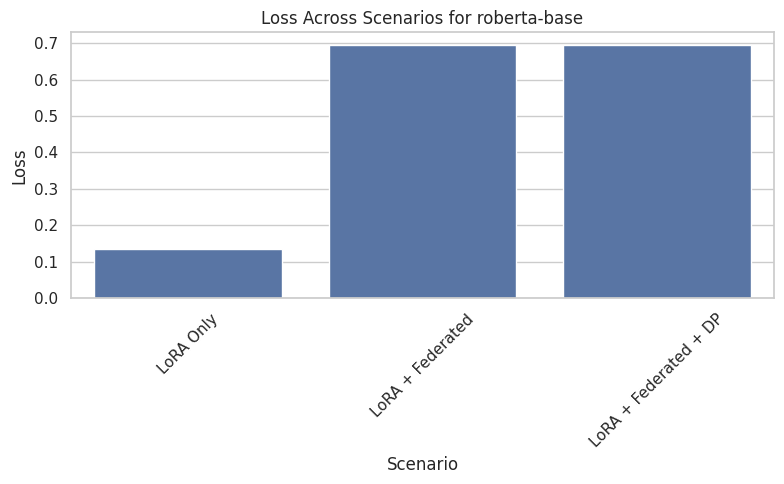

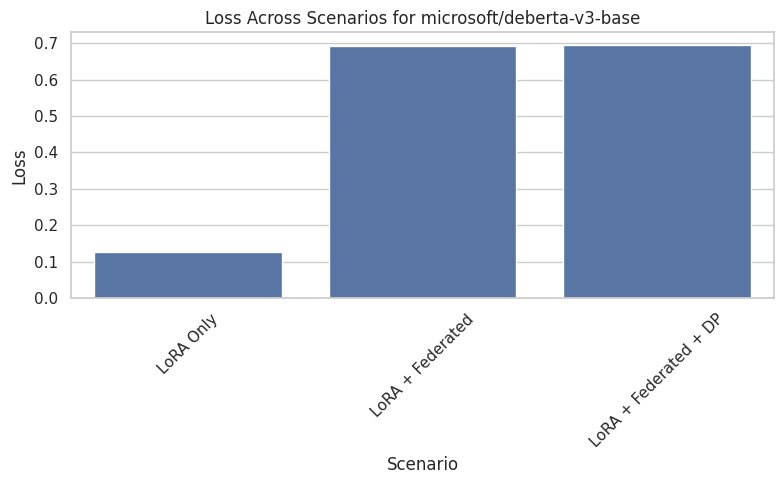

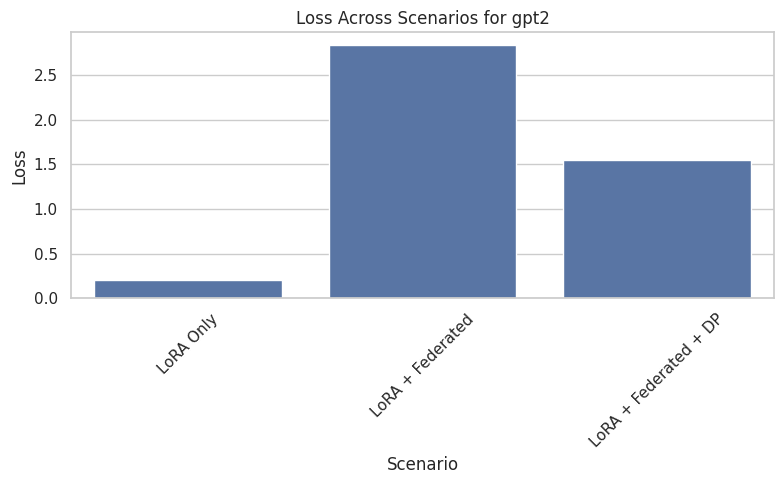

In [14]:
# Loss visualization for each model
for model_name in results_df["Model"].unique():
    # Filter data for the current model
    model_data = results_df[results_df["Model"] == model_name]
    
    # Create barplot for the current model
    plt.figure(figsize=(8, 5))
    sns.barplot(data=model_data, x="Scenario", y="Loss", hue="Model", dodge=False)
    plt.title(f"Loss Across Scenarios for {model_name}")
    plt.ylabel("Loss")
    plt.xlabel("Scenario")
    plt.xticks(rotation=45)
    plt.legend([], [], frameon=False)  # Hide legend since it's redundant
    plt.tight_layout()
    plt.show()
    plt.close()

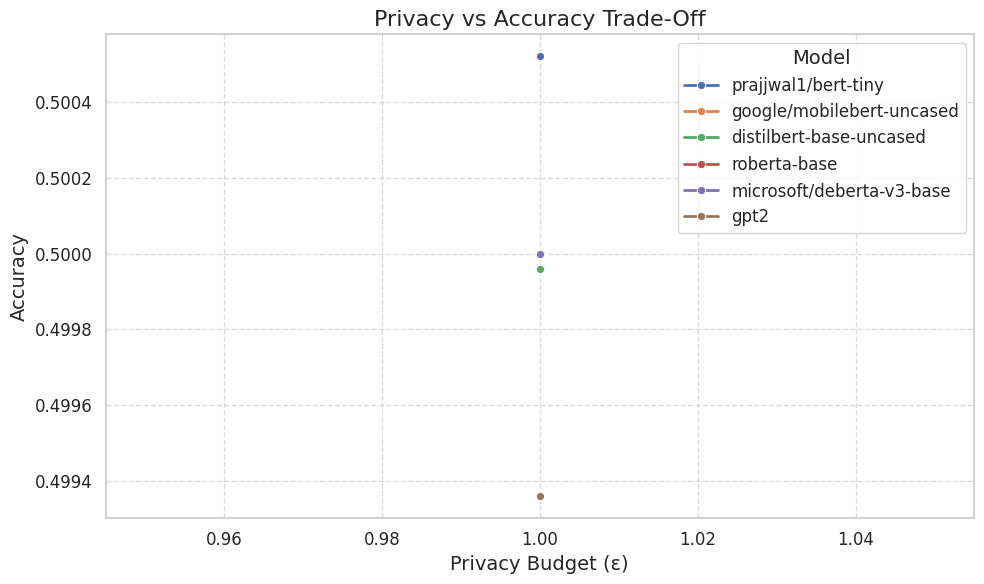

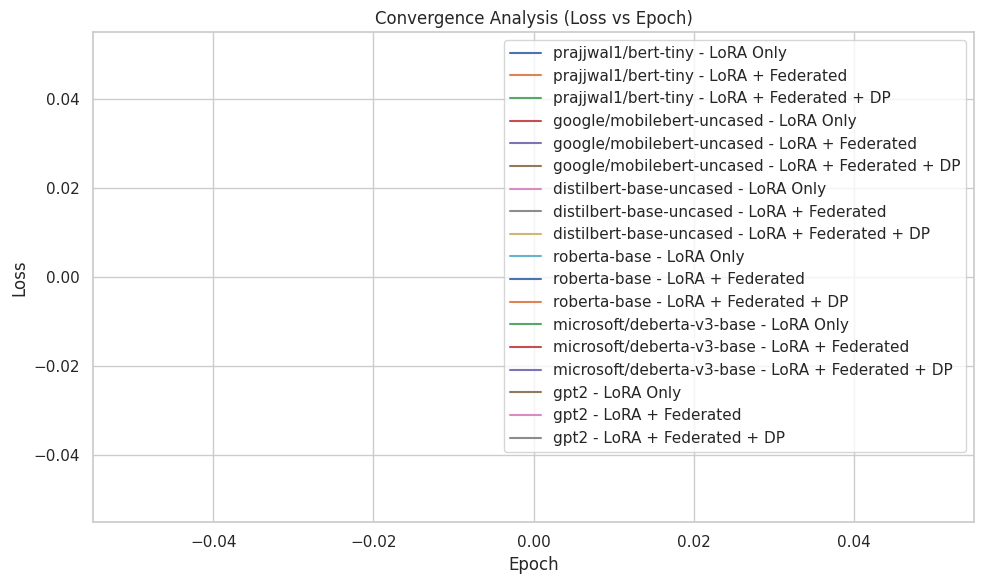

In [17]:
# Filter results with non-null Privacy Budget (ε)
dp_results = results_df[results_df["Privacy Budget (ε)"].notnull()]

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size for better clarity
sns.lineplot(
    data=dp_results, 
    x="Privacy Budget (ε)", 
    y="Accuracy", 
    hue="Model", 
    marker="o", 
    linewidth=2  # Make the lines thicker for visibility
)

# Add plot title and axis labels
plt.title("Privacy vs Accuracy Trade-Off", fontsize=16)
plt.xlabel("Privacy Budget (ε)", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

# Improve the layout and readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Model", fontsize=12, title_fontsize=14, loc="best")  # Improve legend placement and readability

plt.grid(True, linestyle="--", alpha=0.7)  # Add a grid for better visual alignment
plt.tight_layout()
plt.show()

# Convergence Analysis
plt.figure(figsize=(10, 6))
for model_name in models_to_test:
    model_data = results_df[results_df["Model"] == model_name["name"]]
    for _, row in model_data.iterrows():
        plt.plot(range(len(loss_history)), loss_history, label=f"{row['Model']} - {row['Scenario']}")

plt.title("Convergence Analysis (Loss vs Epoch)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


Metrics for prajjwal1/bert-tiny - LoRA Only:
Accuracy: 0.78
Precision: 0.78
Recall: 0.78
F1 Score: 0.78
ROC-AUC: 0.8686650912


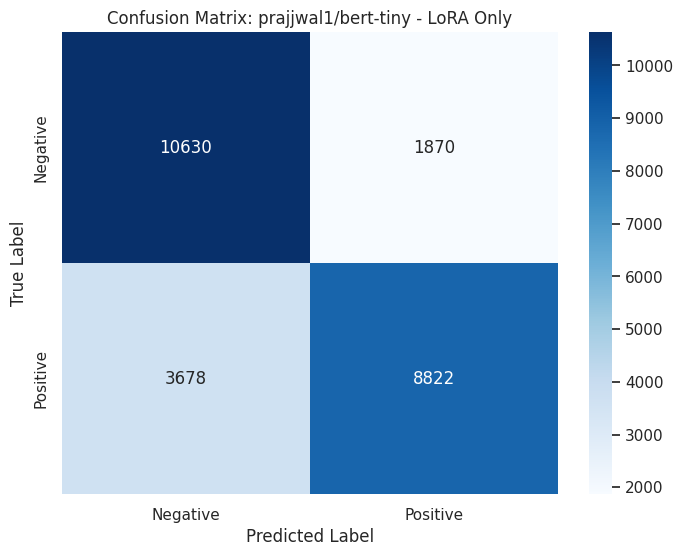

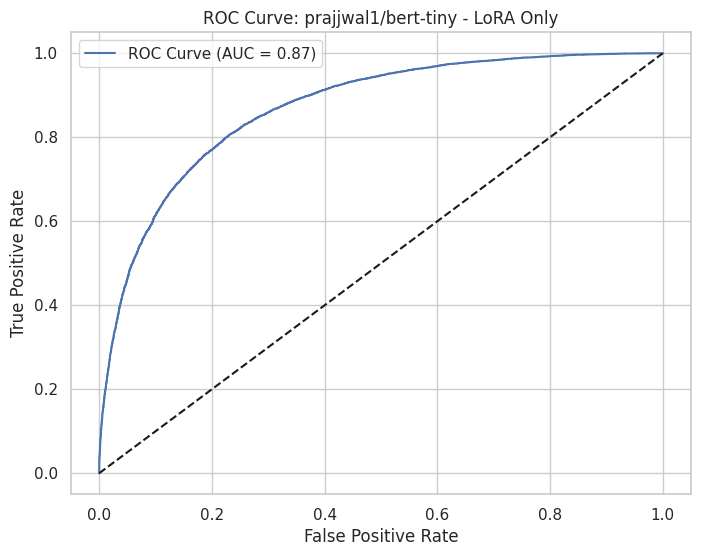


Metrics for prajjwal1/bert-tiny - LoRA + Federated:
Accuracy: 0.50
Precision: 0.25
Recall: 0.50
F1 Score: 0.33
ROC-AUC: 0.4094723584


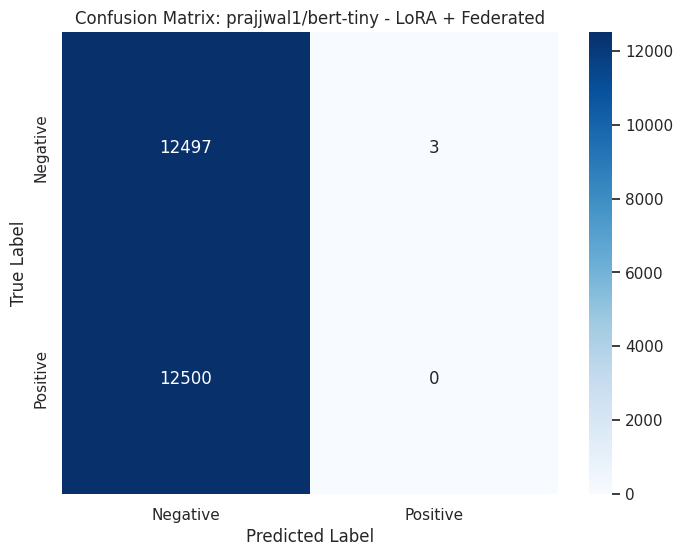

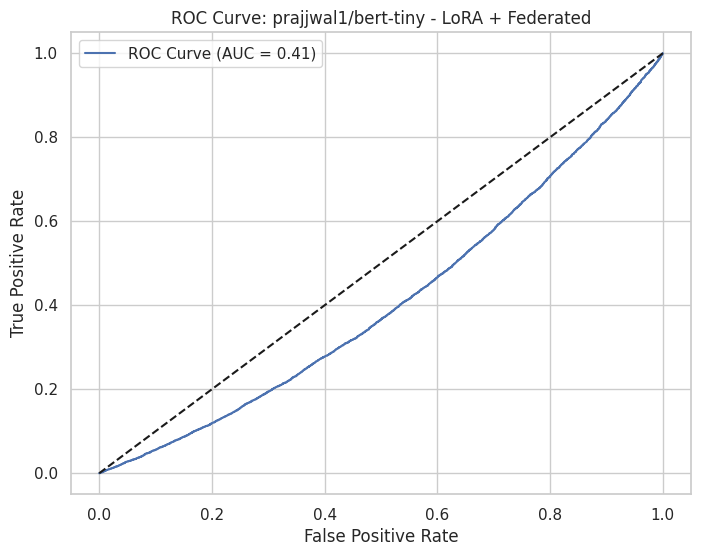


Metrics for prajjwal1/bert-tiny - LoRA + Federated + DP:
Accuracy: 0.50
Precision: 0.54
Recall: 0.50
F1 Score: 0.34
ROC-AUC: 0.4364763584


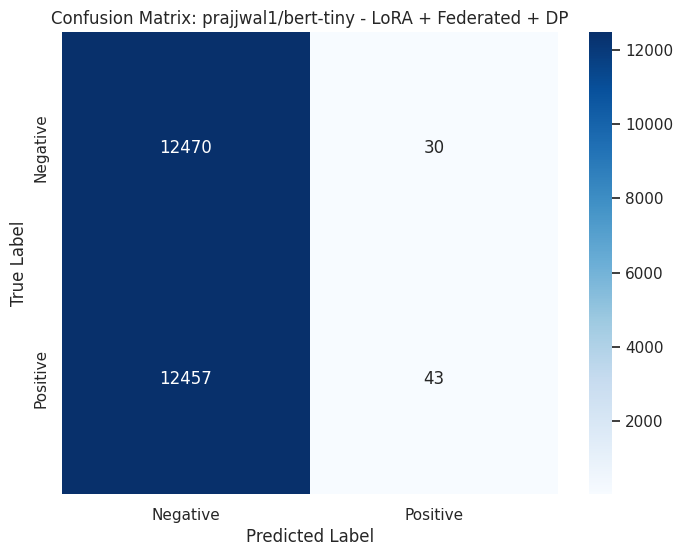

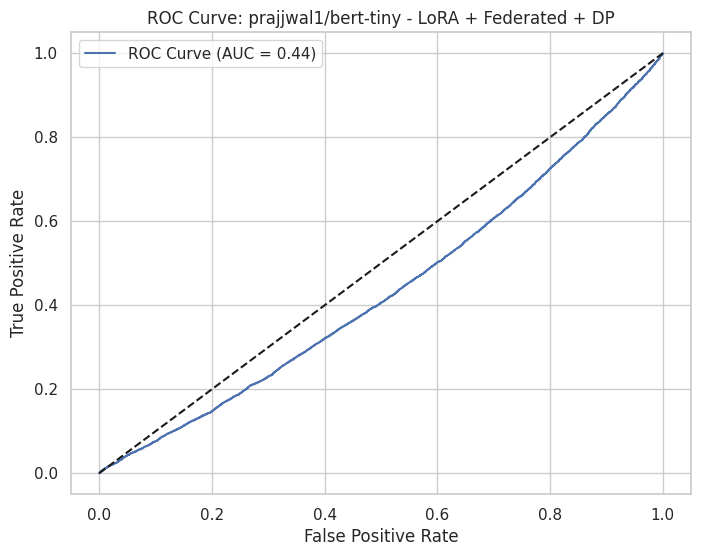


Metrics for google/mobilebert-uncased - LoRA Only:
Accuracy: 0.50
Precision: 0.42
Recall: 0.50
F1 Score: 0.34
ROC-AUC: 0.5076152896


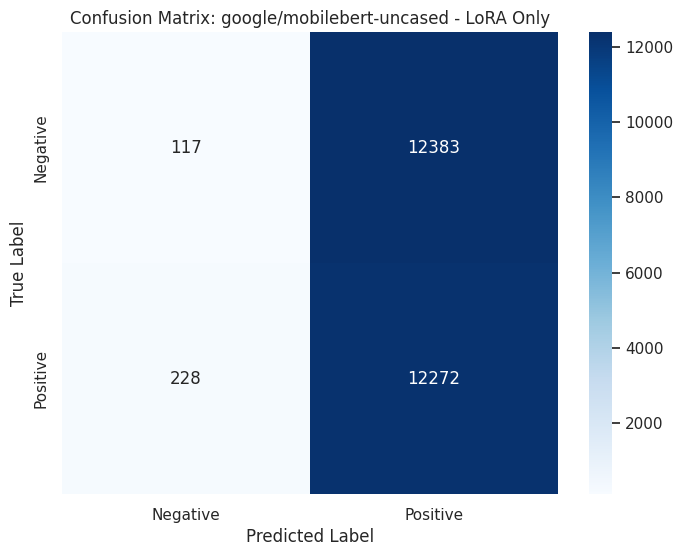

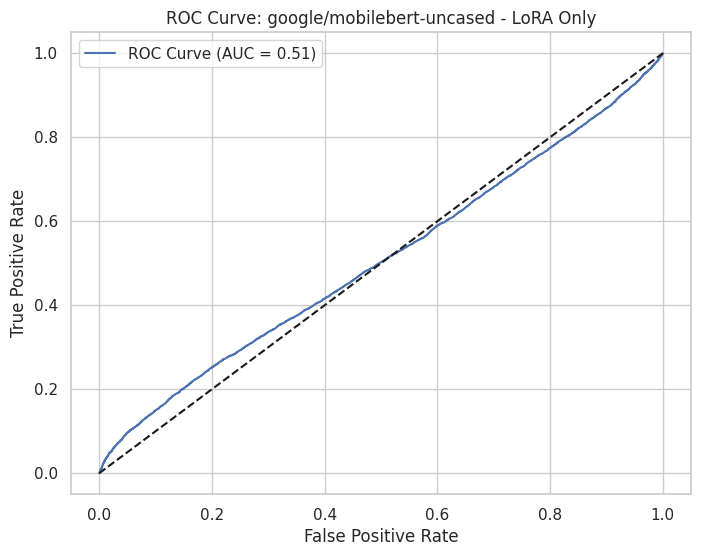


Metrics for google/mobilebert-uncased - LoRA + Federated:
Accuracy: 0.50
Precision: 0.25
Recall: 0.50
F1 Score: 0.33
ROC-AUC: 0.5


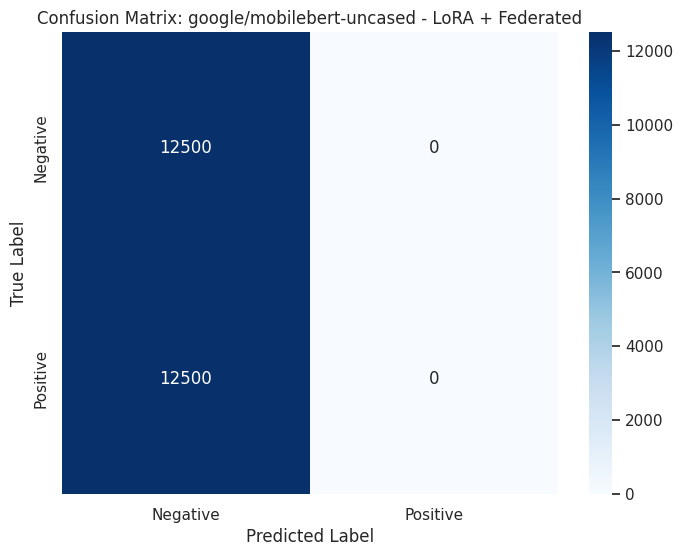

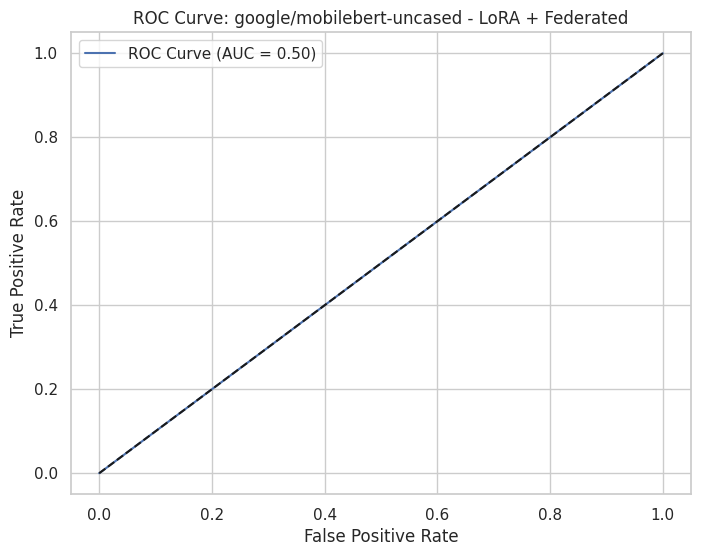


Metrics for google/mobilebert-uncased - LoRA + Federated + DP:
Accuracy: 0.50
Precision: 0.25
Recall: 0.50
F1 Score: 0.33
ROC-AUC: 0.5


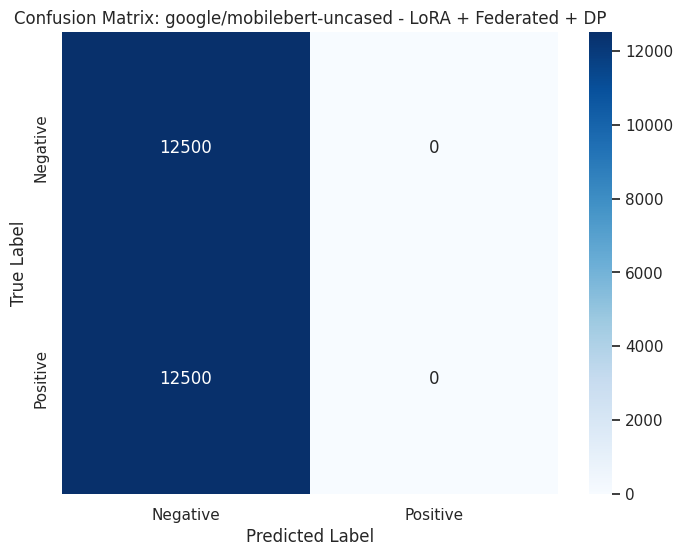

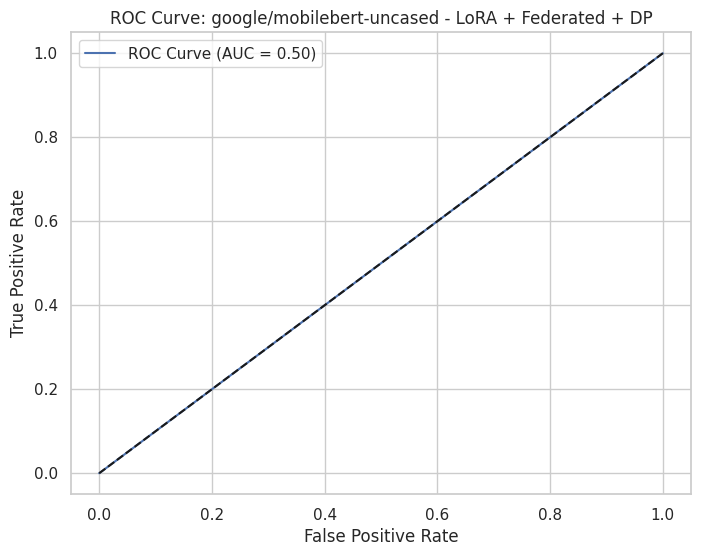


Metrics for distilbert-base-uncased - LoRA Only:
Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1 Score: 0.91
ROC-AUC: 0.9729528064


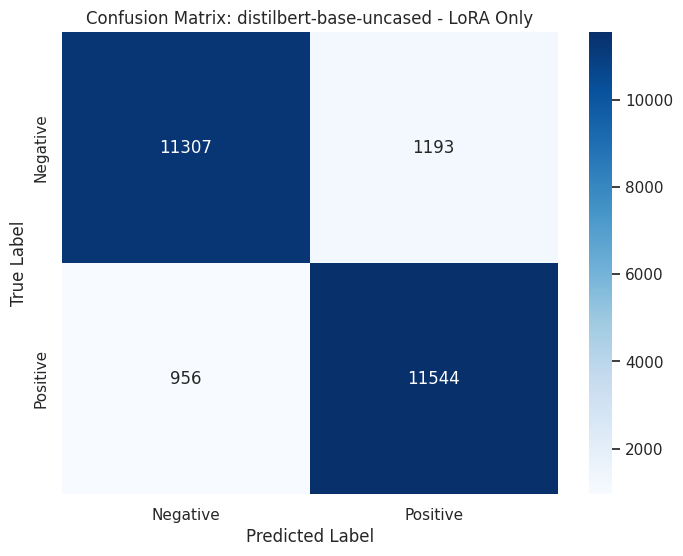

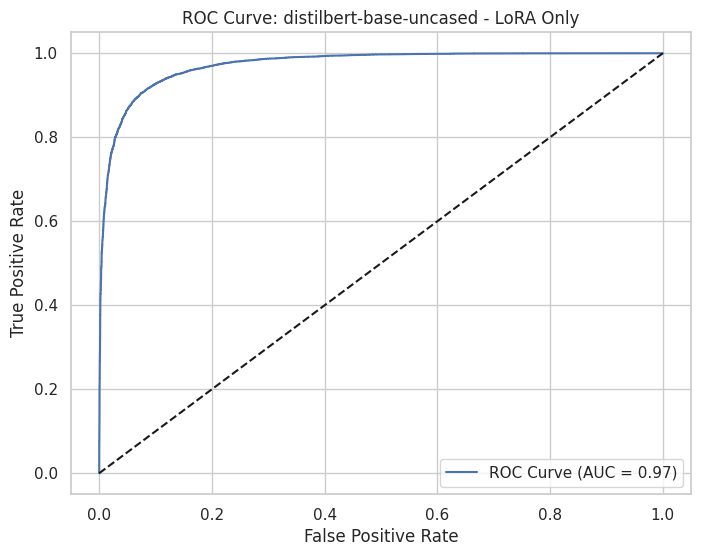


Metrics for distilbert-base-uncased - LoRA + Federated:
Accuracy: 0.50
Precision: 0.25
Recall: 0.50
F1 Score: 0.33
ROC-AUC: 0.4445502144


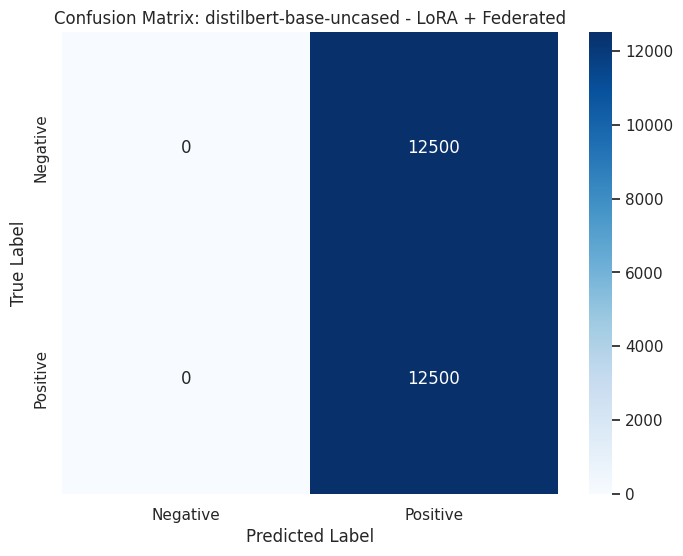

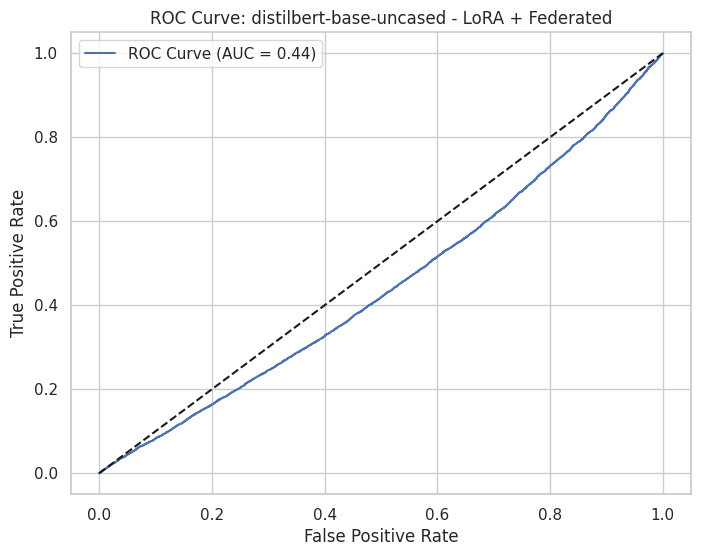


Metrics for distilbert-base-uncased - LoRA + Federated + DP:
Accuracy: 0.50
Precision: 0.25
Recall: 0.50
F1 Score: 0.33
ROC-AUC: 0.43856410879999996


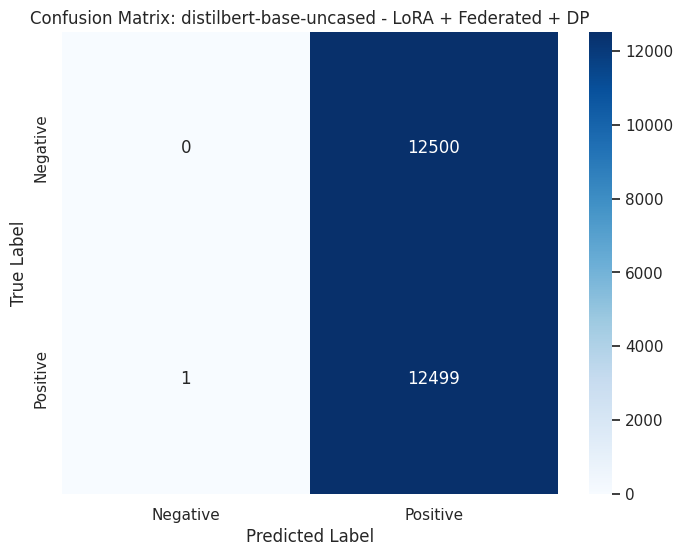

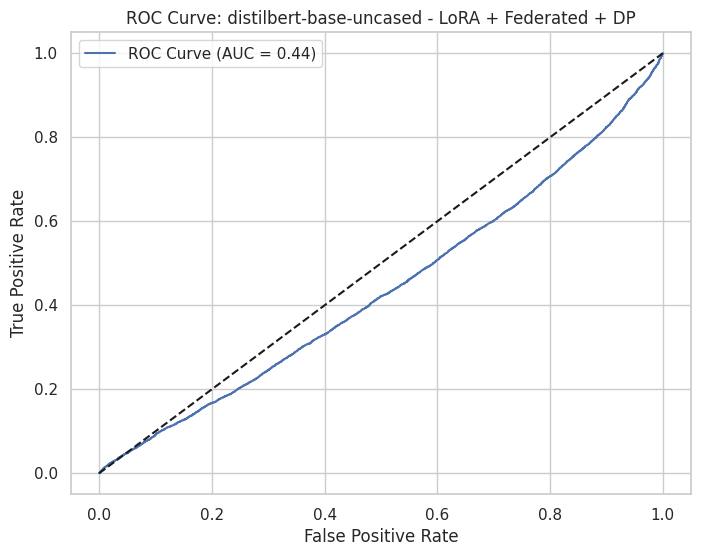


Metrics for roberta-base - LoRA Only:
Accuracy: 0.95
Precision: 0.95
Recall: 0.95
F1 Score: 0.95
ROC-AUC: 0.9884756543999998


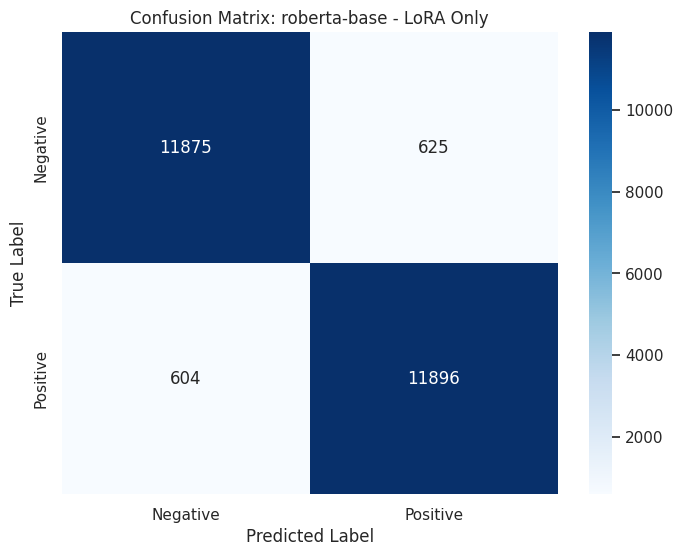

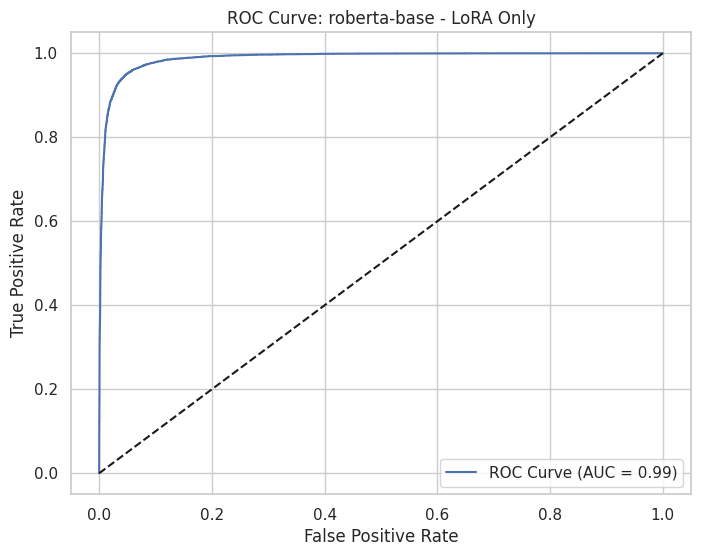


Metrics for roberta-base - LoRA + Federated:
Accuracy: 0.50
Precision: 0.25
Recall: 0.50
F1 Score: 0.33
ROC-AUC: 0.5547734848


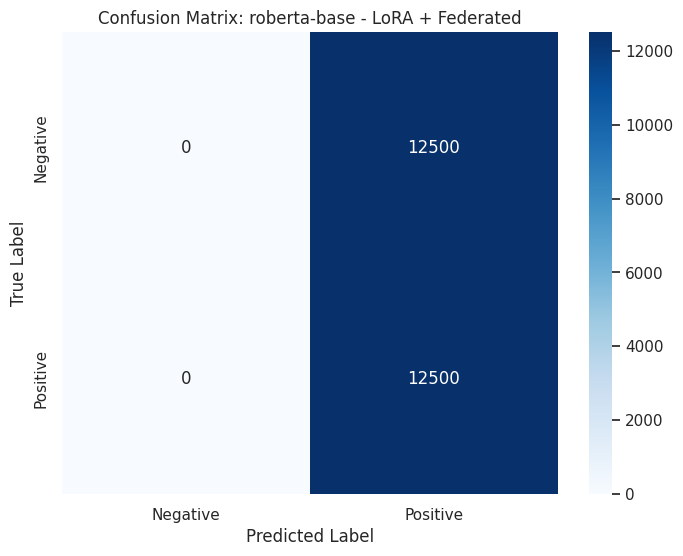

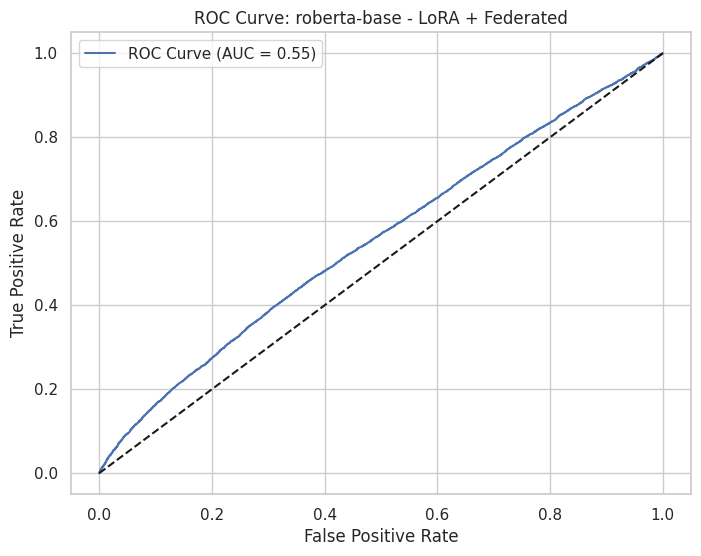


Metrics for roberta-base - LoRA + Federated + DP:
Accuracy: 0.50
Precision: 0.25
Recall: 0.50
F1 Score: 0.33
ROC-AUC: 0.5146266911999999


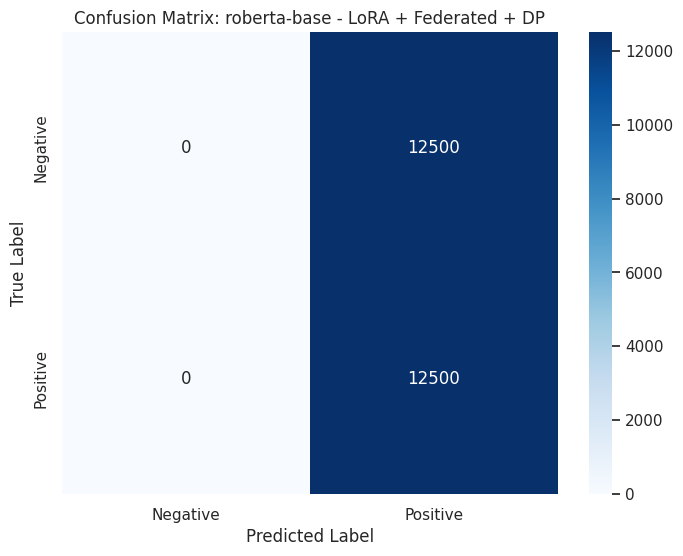

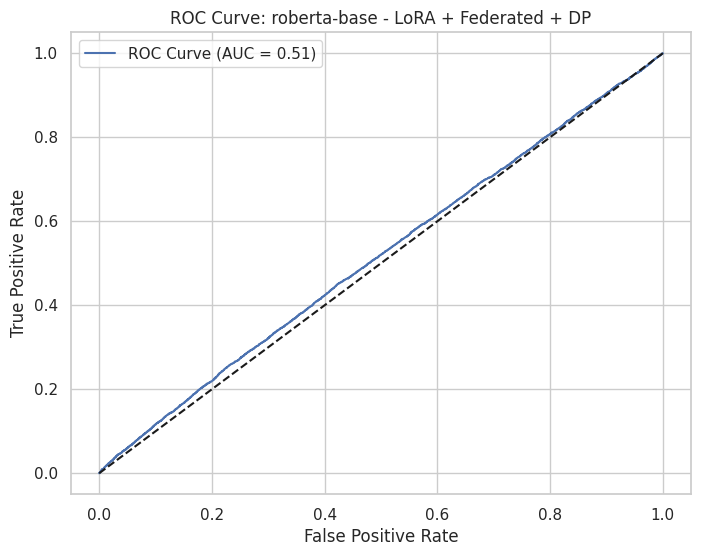


Metrics for microsoft/deberta-v3-base - LoRA Only:
Accuracy: 0.96
Precision: 0.96
Recall: 0.96
F1 Score: 0.96
ROC-AUC: 0.9898054304


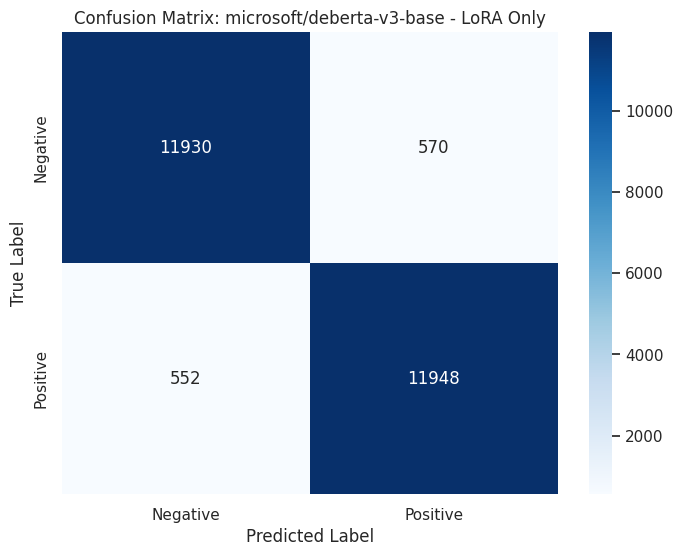

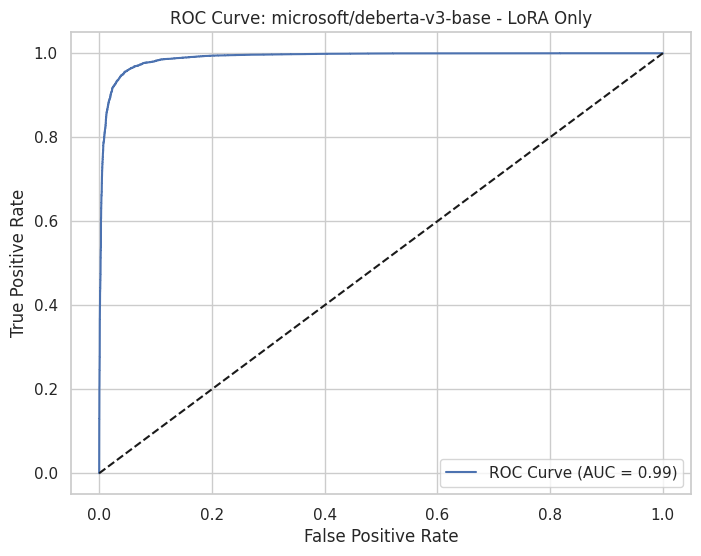


Metrics for microsoft/deberta-v3-base - LoRA + Federated:
Accuracy: 0.50
Precision: 0.25
Recall: 0.50
F1 Score: 0.33
ROC-AUC: 0.5280063328


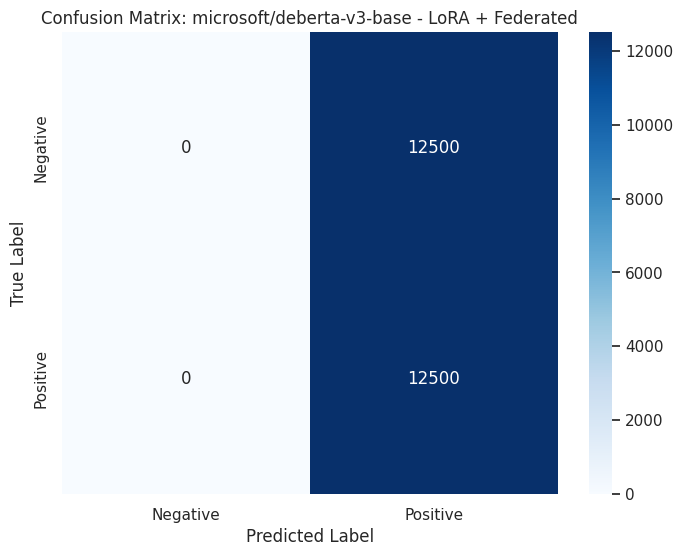

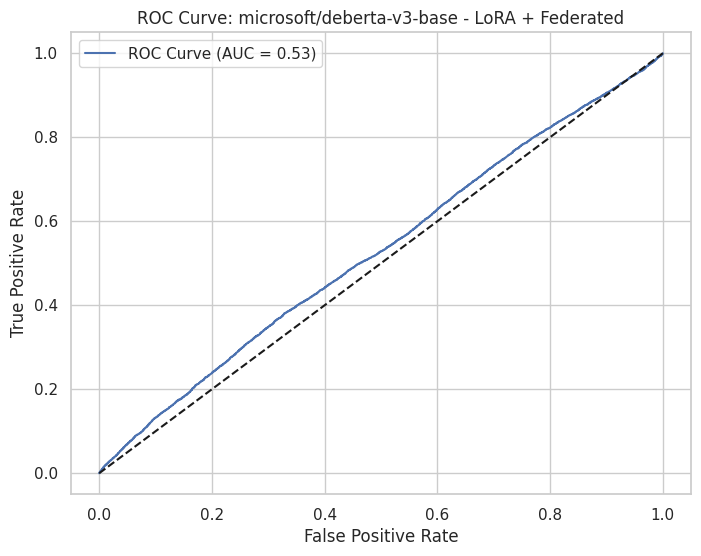


Metrics for microsoft/deberta-v3-base - LoRA + Federated + DP:
Accuracy: 0.50
Precision: 0.25
Recall: 0.50
F1 Score: 0.33
ROC-AUC: 0.5140781024000001


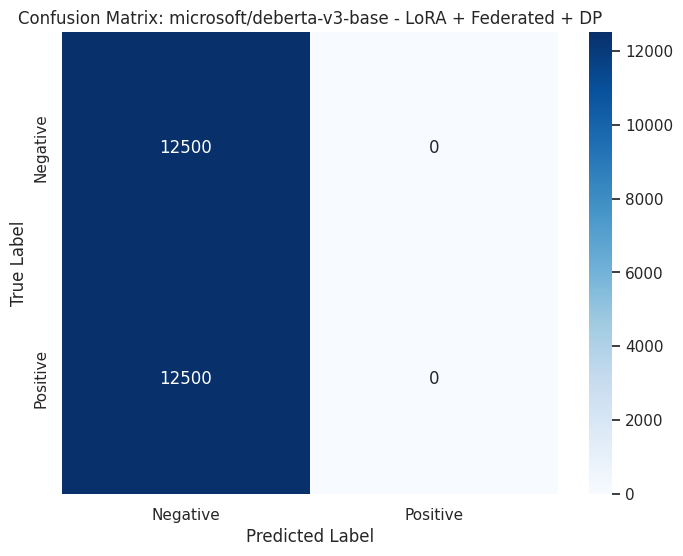

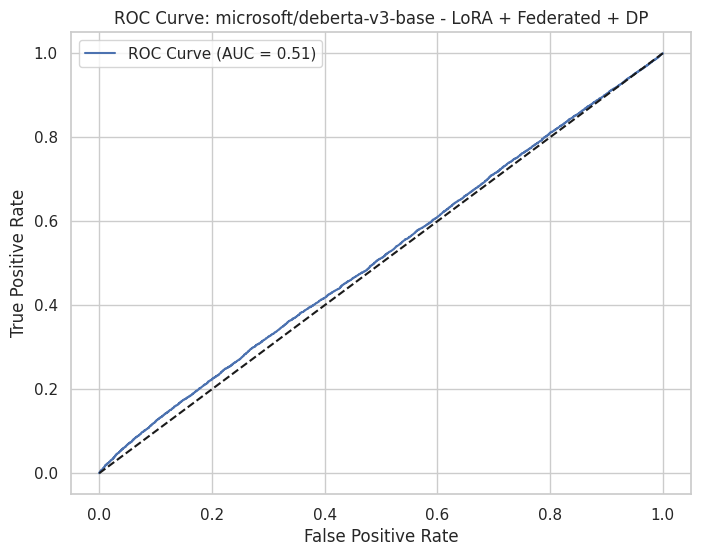


Metrics for gpt2 - LoRA Only:
Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1 Score: 0.92
ROC-AUC: 0.9764475552


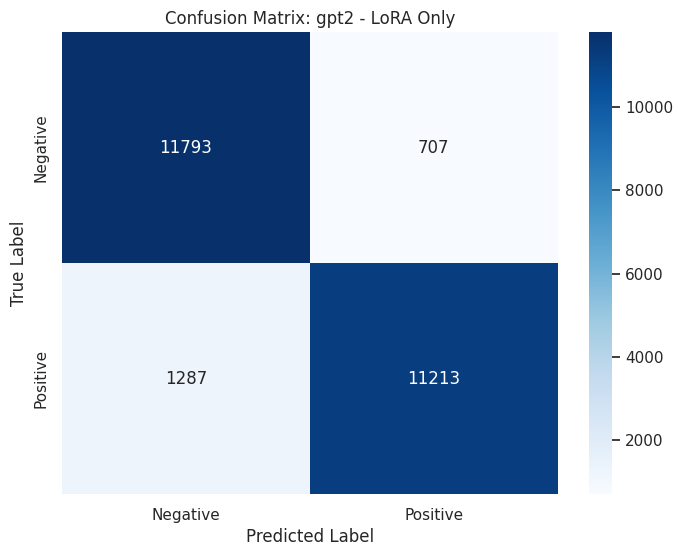

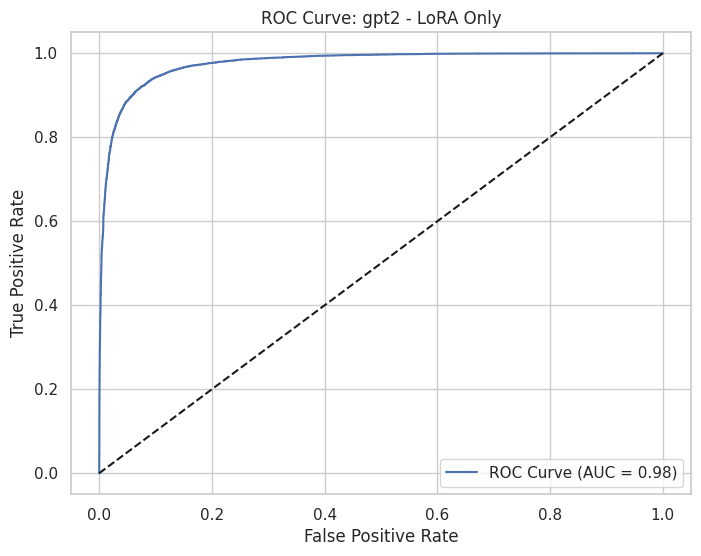


Metrics for gpt2 - LoRA + Federated:
Accuracy: 0.50
Precision: 0.50
Recall: 0.50
F1 Score: 0.34
ROC-AUC: 0.6051627904


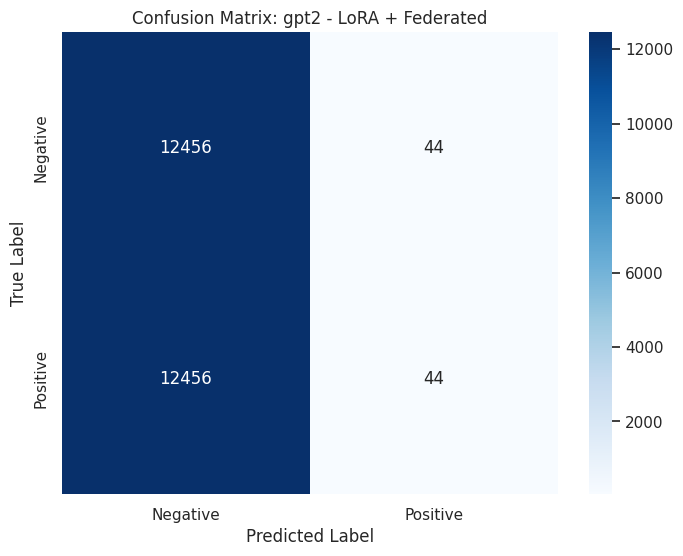

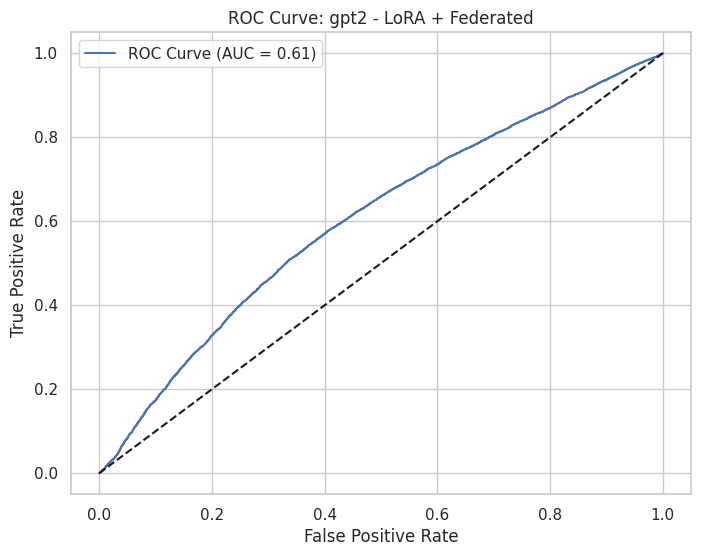


Metrics for gpt2 - LoRA + Federated + DP:
Accuracy: 0.50
Precision: 0.48
Recall: 0.50
F1 Score: 0.34
ROC-AUC: 0.5721815904


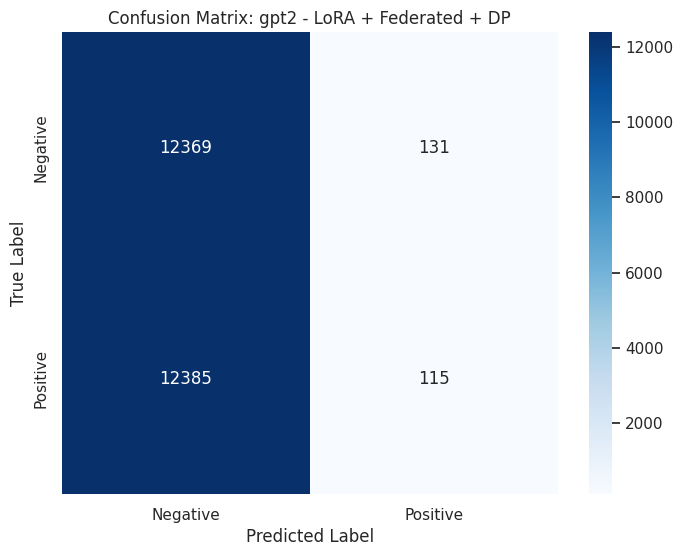

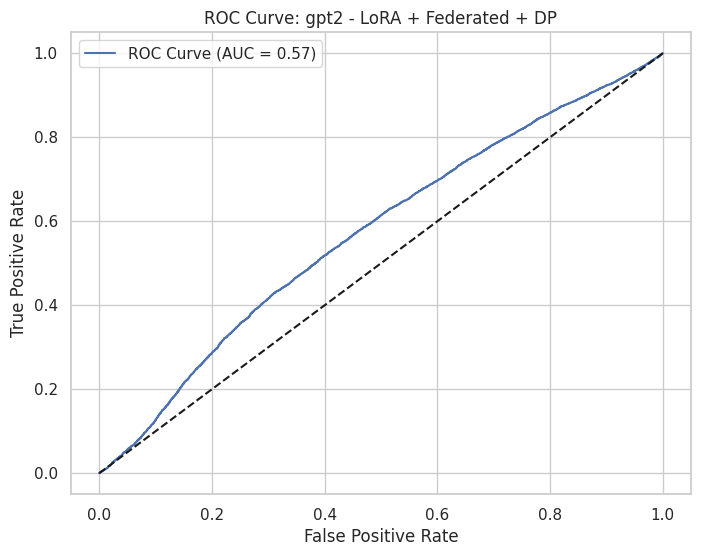

In [13]:
# for _, result in results_df.iterrows():
#     # Visualize metrics for the current experiment
#     print(f"\nMetrics for {result['Model']} - {result['Scenario']}:")
#     print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}, ROC-AUC: {roc_auc if roc_auc else 'N/A'}")

#     plt.figure(figsize=(8, 6))
#     sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.title(f"Confusion Matrix: {result['Model']} - {result['Scenario']}")
#     plt.show()

#     if roc_auc:
#         fpr, tpr, _ = roc_curve(all_labels, [p[1] for p in all_probs])
#         plt.figure(figsize=(8, 6))
#         plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
#         plt.plot([0, 1], [0, 1], "k--")
#         plt.xlabel("False Positive Rate")
#         plt.ylabel("True Positive Rate")
#         plt.title(f"ROC Curve: {result['Model']} - {result['Scenario']}")
#         plt.legend()
#         plt.show()



# Generate visuals for all models and scenarios
for (model_name, scenario_name), data in evaluation_data.items():
    all_labels = data["all_labels"]
    all_probs = data["all_probs"]
    conf_matrix = data["conf_matrix"]

    # Fetch roc_auc from results_df
    try:
        roc_auc = results_df[
            (results_df['Model'] == model_name) & 
            (results_df['Scenario'] == scenario_name)
        ]['ROC-AUC'].values[0]
    except IndexError:
        roc_auc = None  # If not found, set to None

    print(f"\nMetrics for {model_name} - {scenario_name}:")
    print(f"Accuracy: {results_df[(results_df['Model'] == model_name) & (results_df['Scenario'] == scenario_name)]['Accuracy'].values[0]:.2f}")
    print(f"Precision: {results_df[(results_df['Model'] == model_name) & (results_df['Scenario'] == scenario_name)]['Precision'].values[0]:.2f}")
    print(f"Recall: {results_df[(results_df['Model'] == model_name) & (results_df['Scenario'] == scenario_name)]['Recall'].values[0]:.2f}")
    print(f"F1 Score: {results_df[(results_df['Model'] == model_name) & (results_df['Scenario'] == scenario_name)]['F1 Score'].values[0]:.2f}")
    print(f"ROC-AUC: {roc_auc if roc_auc else 'N/A'}")

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {model_name} - {scenario_name}")
    plt.show()

    # ROC Curve
    if roc_auc and len(set(all_labels)) == 2:  # Ensure binary classification
        fpr, tpr, _ = roc_curve(all_labels, [p[1] for p in all_probs])
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve: {model_name} - {scenario_name}")
        plt.legend()
        plt.show()

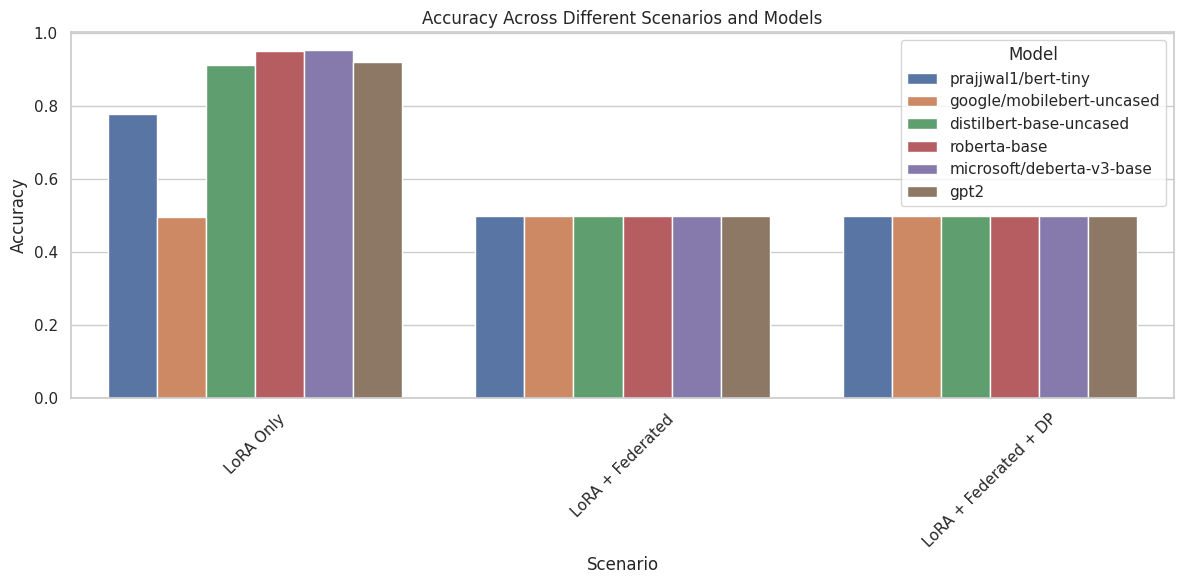

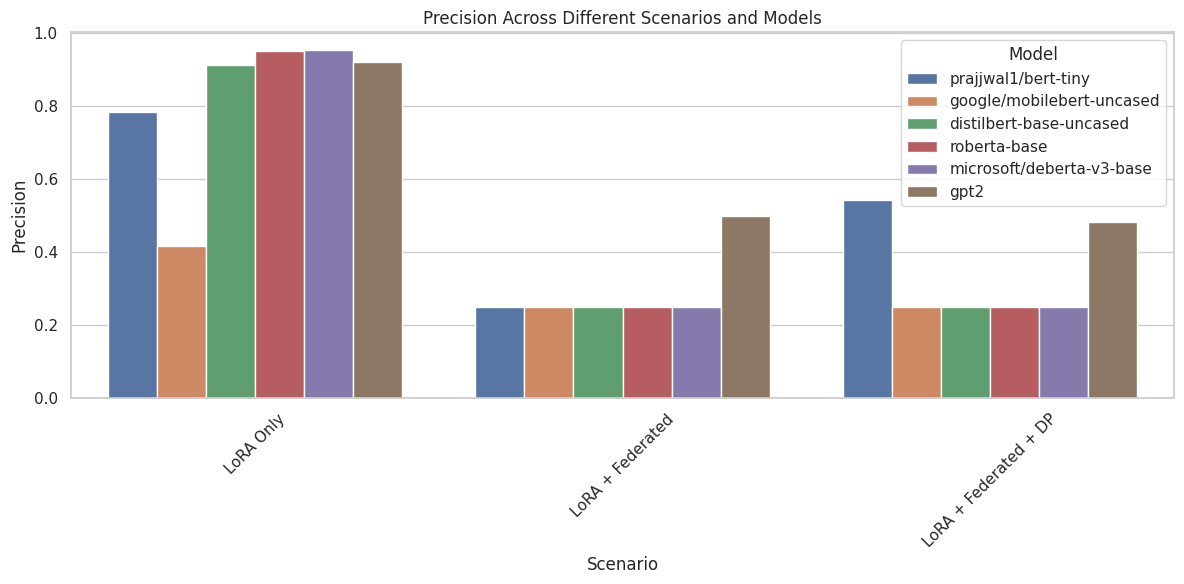

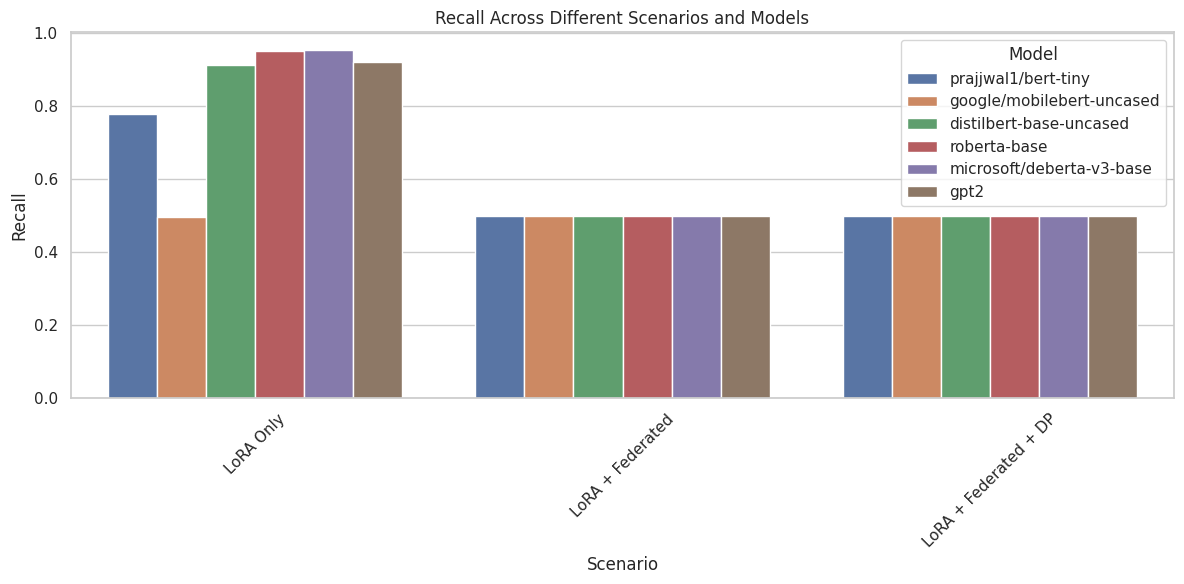

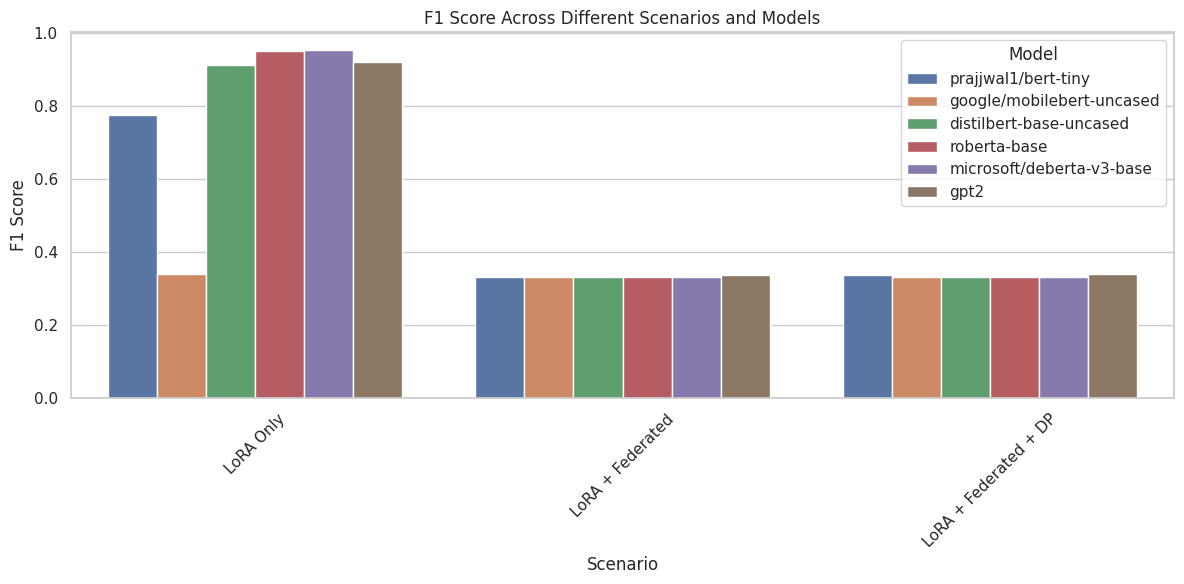

In [7]:
metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1 Score"]
for metric in metrics_to_plot:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df, x="Scenario", y=metric, hue="Model")
    plt.title(f"{metric} Across Different Scenarios and Models")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()

plt.close()

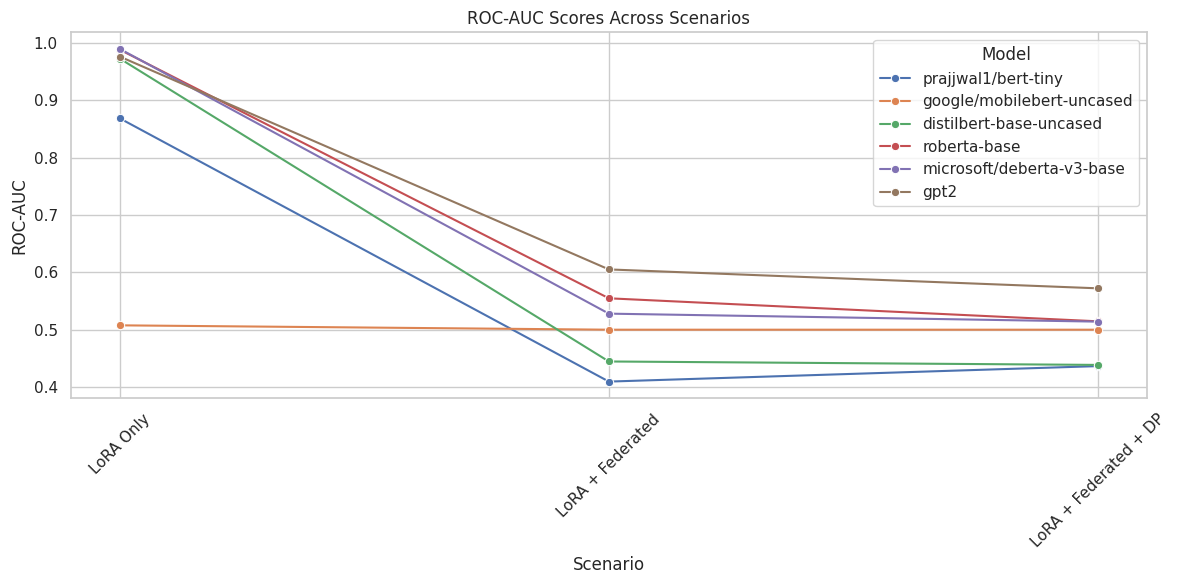

In [8]:
# Line plot for ROC-AUC comparison
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="Scenario", y="ROC-AUC", hue="Model", marker="o")
plt.title("ROC-AUC Scores Across Scenarios")
plt.ylabel("ROC-AUC")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

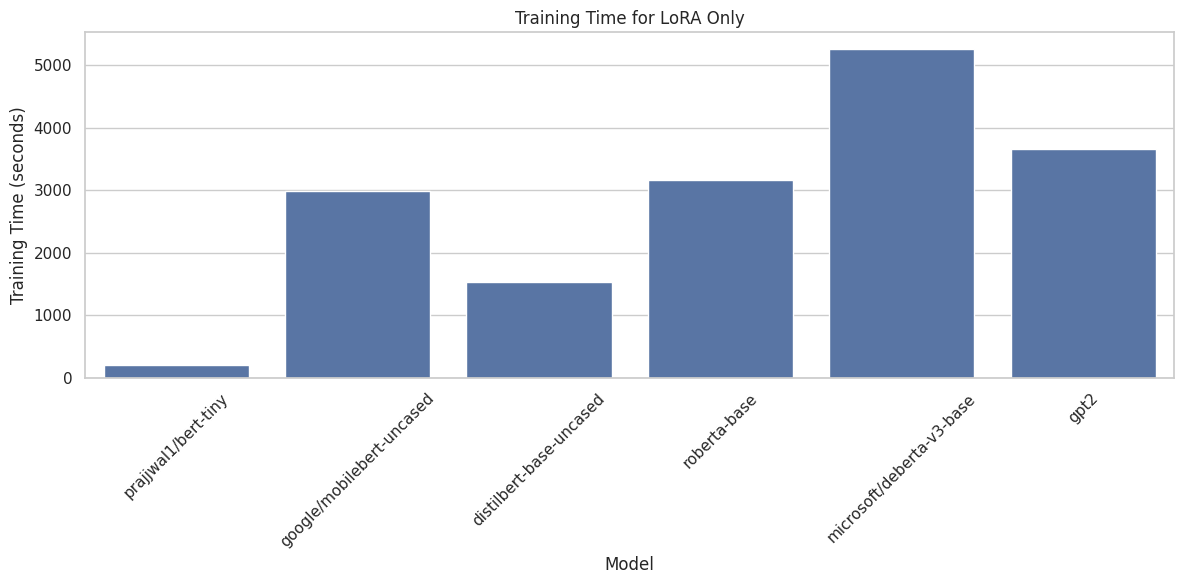

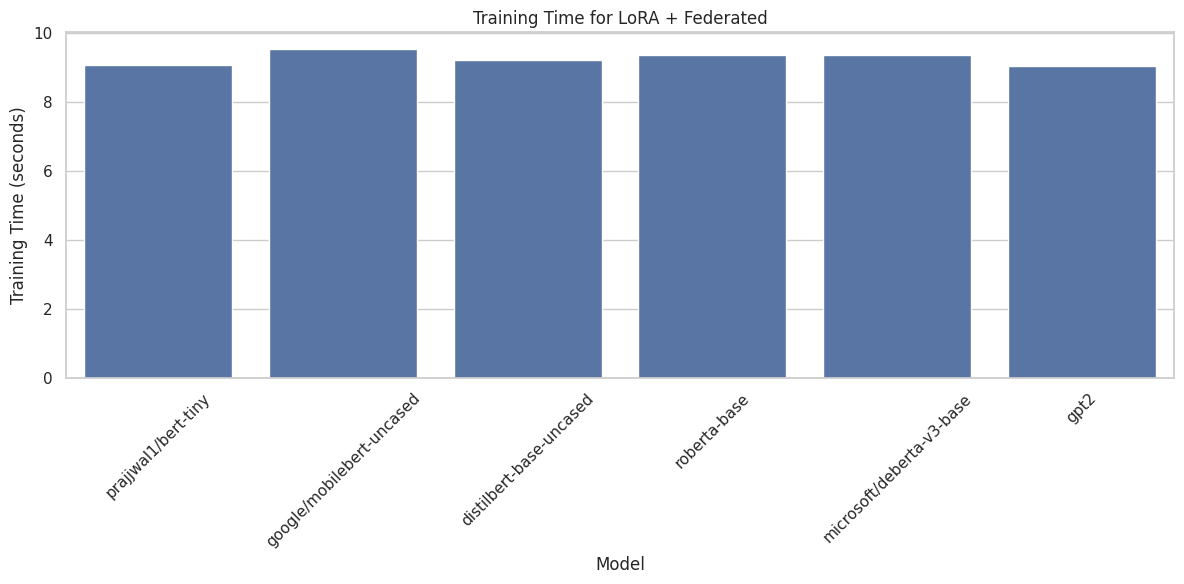

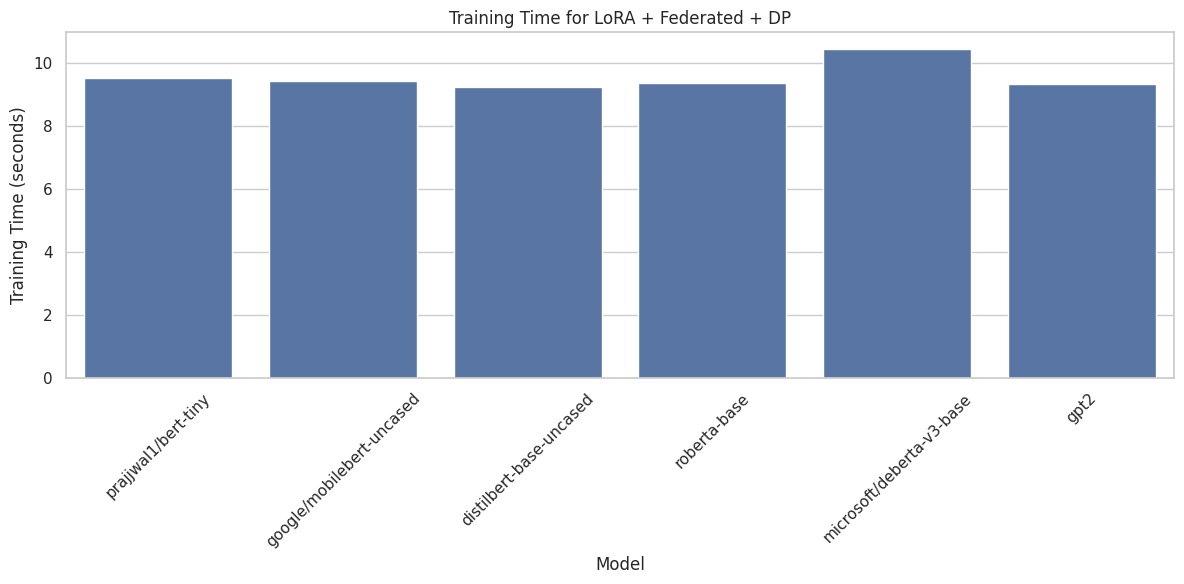

In [9]:
# Filter the data by scenario and create separate plots
scenarios = results_df["Scenario"].unique()

for scenario in scenarios:
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=results_df[results_df["Scenario"] == scenario],
        x="Model",
        y="Training Time (s)",
    )
    plt.title(f"Training Time for {scenario}")
    plt.ylabel("Training Time (seconds)")
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

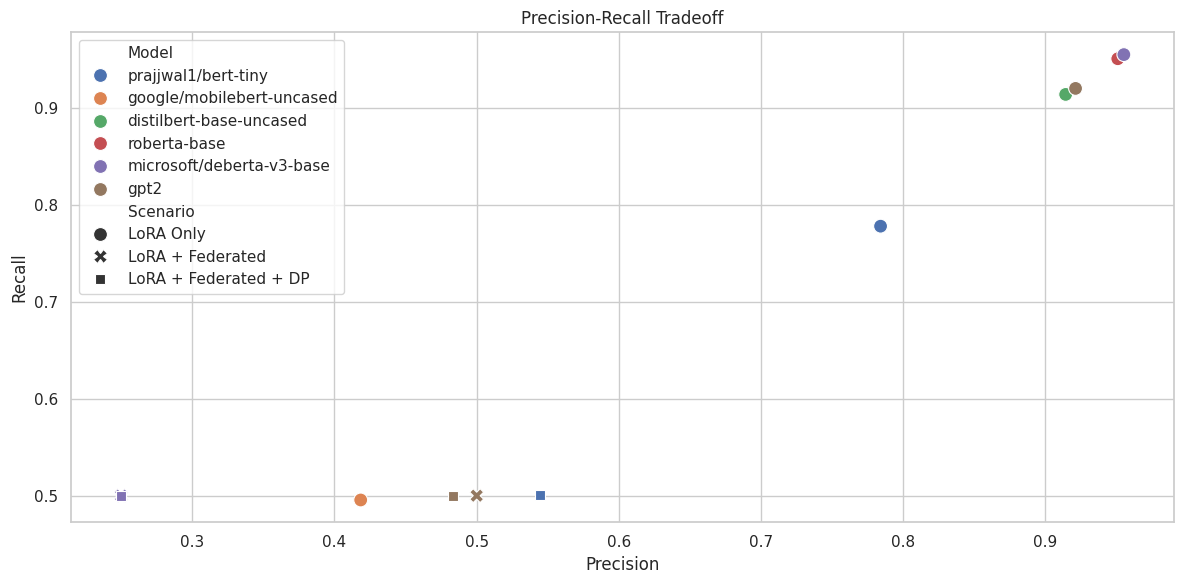

In [10]:
# Scatter plot for precision vs recall
plt.figure(figsize=(12, 6))
sns.scatterplot(data=results_df, x="Precision", y="Recall", hue="Model", style="Scenario", s=100)
plt.title("Precision-Recall Tradeoff")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.tight_layout()
plt.show()

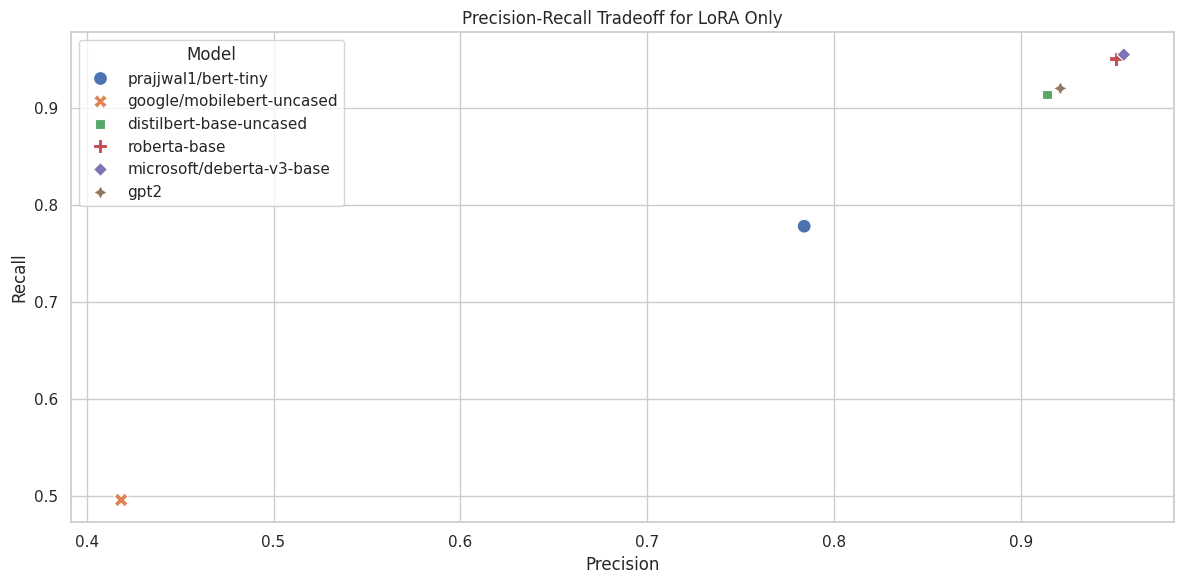

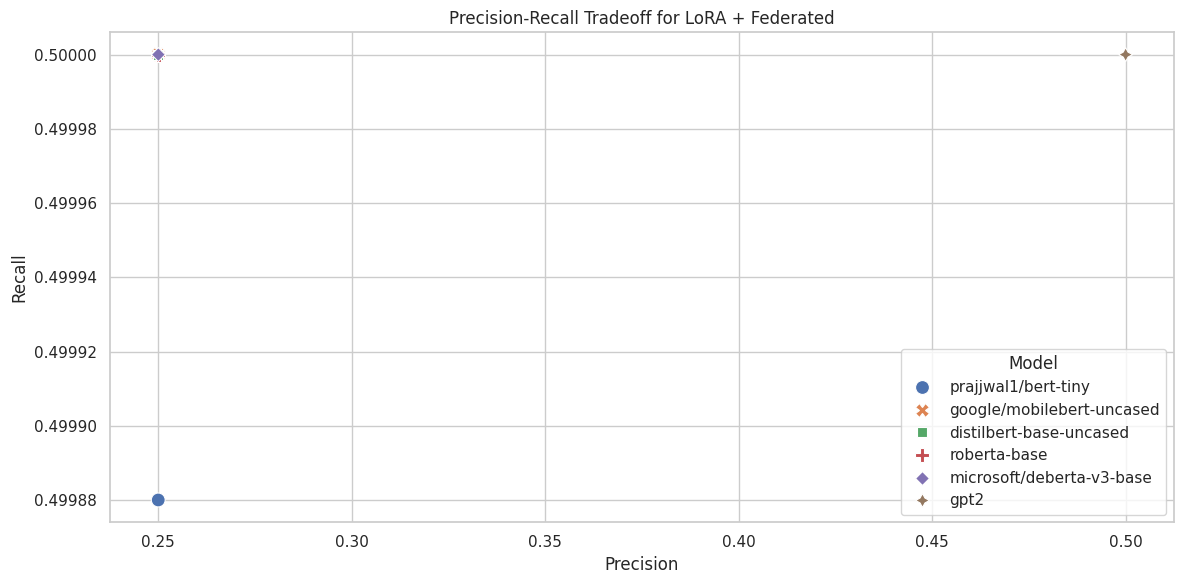

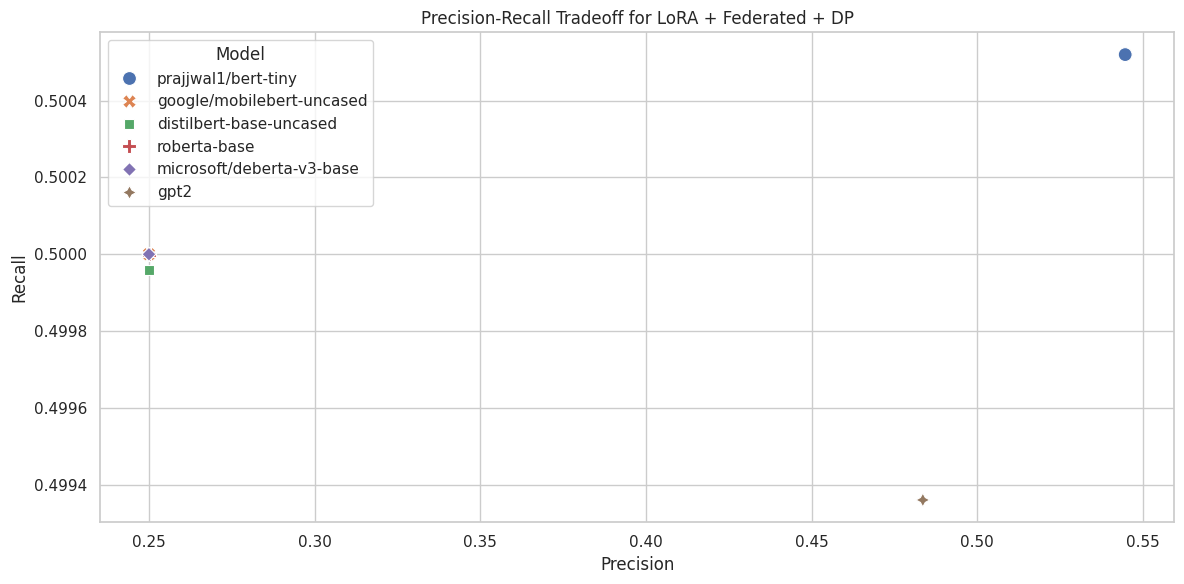

In [11]:
# Filter the data by scenario and create separate scatter plots
scenarios = results_df["Scenario"].unique()

for scenario in scenarios:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(
        data=results_df[results_df["Scenario"] == scenario],
        x="Precision",
        y="Recall",
        hue="Model",
        style="Model",
        s=100,
    )
    plt.title(f"Precision-Recall Tradeoff for {scenario}")
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.legend(title="Model", loc="best")
    plt.tight_layout()
    plt.show()

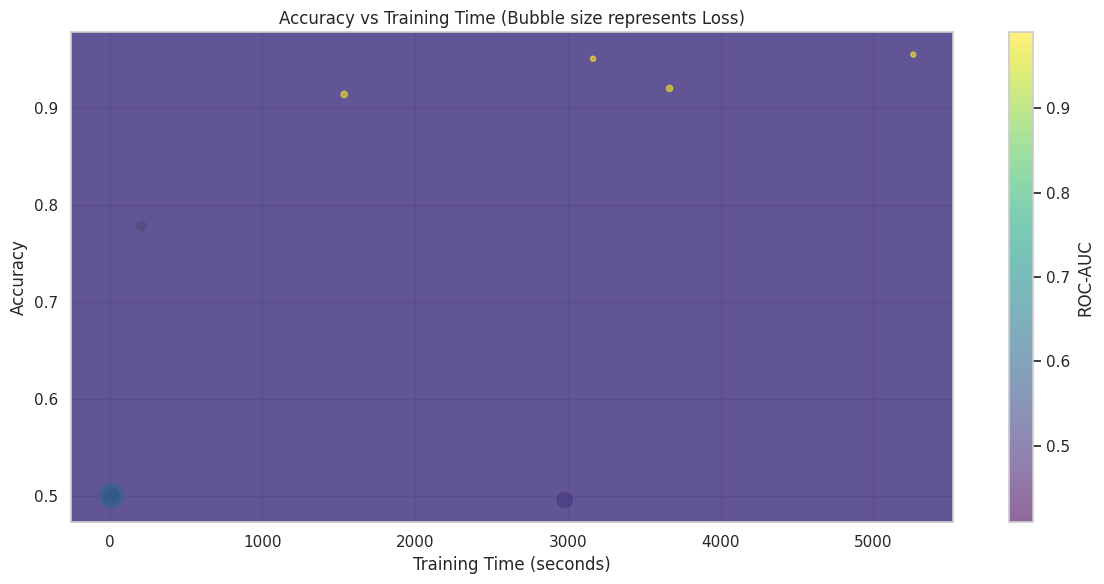

In [12]:
# Bubble plot for accuracy vs training time
plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    results_df["Training Time (s)"],
    results_df["Accuracy"],
    s=results_df["Loss"] * 100,  # Scale bubble size by loss
    alpha=0.6,
    c=results_df["ROC-AUC"],  # Color by ROC-AUC
    cmap="viridis",
)
plt.colorbar(scatter, label="ROC-AUC")
plt.title("Accuracy vs Training Time (Bubble size represents Loss)")
plt.xlabel("Training Time (seconds)")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()